In [1]:
import warnings
warnings.filterwarnings('ignore')

# 1. Binary classification

Binary classification is a supervised learning problem in which we want to predict the class of an observation among two possible classes. In this notebook, we will see how to solve a binary classification problem using a neural network.

## 1.1. Get data ready

### 1.1.1. Create a dummy dataset for binary classification

In [2]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, noise=0.03, random_state=42)

In [3]:
X.shape, type(X), X.dtype, y.shape, type(y), y.dtype

((1000, 2),
 numpy.ndarray,
 dtype('float64'),
 (1000,),
 numpy.ndarray,
 dtype('int64'))

In [4]:
import pandas as pd

circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


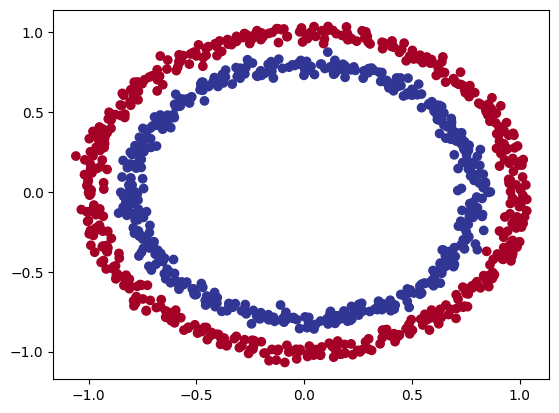

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

### 1.1.2. Turn data into tensors

In [6]:
import torch

torch.__version__

'2.1.0'

In [7]:
# `torch.tensor()`: copy the original data, not sharing memory, and can work with a broader range of data types
# `torch.from_numpy()`: tensor shares memory with a numpy array, thus saving memory

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

X.shape, type(X), X.dtype, y.shape, type(y), y.dtype

(torch.Size([1000, 2]),
 torch.Tensor,
 torch.float32,
 torch.Size([1000]),
 torch.Tensor,
 torch.float32)

### 1.1.3. Make train/test splits

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [9]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

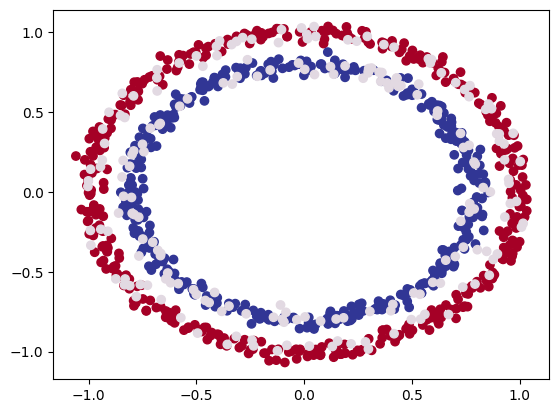

In [10]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.twilight)
plt.show();

## 1.2. Build a model

### 1.2.1. Setup device agnostic code

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### 1.2.2. Construct a model

#### 1.2.2.1. by subclassing `nn.module`

In [12]:
from torch import nn

class CircleModelV0(nn.Module):
  """"A simple neural network model for binary classification of circles dataset"""
  def __init__(self):
    super().__init__()

    # define layers capable of handling the input data
    self.layer_1 = nn.Linear(in_features=2, out_features=8)
    self.layer_2 = nn.Linear(in_features=8, out_features=1)

    # forward propagation function
    def forward(self, x):
      return self.layer_2(self.layer_1(x))
    
model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [13]:
model0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.2031, -0.1641],
                      [-0.6560, -0.3107],
                      [ 0.2848, -0.1640],
                      [-0.6693, -0.3487],
                      [ 0.1847,  0.3867],
                      [-0.4080, -0.0395],
                      [-0.0522,  0.4177],
                      [ 0.3233, -0.4275]])),
             ('layer_1.bias',
              tensor([-0.3827,  0.2846,  0.2311,  0.4139, -0.5911,  0.0173,  0.4031,  0.3010])),
             ('layer_2.weight',
              tensor([[-0.2545,  0.3258, -0.2259, -0.2019, -0.0668,  0.1081,  0.1698,  0.2067]])),
             ('layer_2.bias', tensor([0.3467]))])

#### 1.2.2.2. by using `nn.Sequential`

In [14]:
model0 = nn.Sequential(
  nn.Linear(in_features=2, out_features=8),
  nn.Linear(in_features=8, out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0264,  0.1079],
                      [ 0.3177, -0.0437],
                      [ 0.6266, -0.4405],
                      [-0.2178,  0.0385],
                      [-0.1265, -0.2174],
                      [ 0.4643,  0.3863],
                      [ 0.3890,  0.2804],
                      [ 0.3143, -0.4589]])),
             ('0.bias',
              tensor([ 0.3569,  0.1755, -0.4035,  0.0177,  0.1130, -0.4890, -0.2700, -0.1356])),
             ('1.weight',
              tensor([[ 0.0906, -0.2897, -0.3406,  0.3033, -0.0498,  0.1263,  0.2410, -0.0071]])),
             ('1.bias', tensor([-0.1130]))])

#### 1.2.2.3. making test predictions

In [16]:
# `untrained_logits`: the output of the model before any additional handling
with torch.inference_mode():
  untrained_logits = model0(X_test.to(device))
untrained_logits.shape, untrained_logits[:5].squeeze()

(torch.Size([200, 1]), tensor([ 0.1743,  0.1785, -0.0697,  0.2445, -0.4397]))

In [17]:
# `untrained_preds_probs`: the probability of the logits after applying the sigmoid function
untrained_preds_probs = torch.sigmoid(untrained_logits)
untrained_preds_probs[:5].squeeze()

tensor([0.5435, 0.5445, 0.4826, 0.5608, 0.3918])

In [18]:
# `untrained_preds`: the predictions after applying the threshold of 0.5
untrained_preds = torch.round(untrained_preds_probs)

y_test[:5], untrained_preds[:5].squeeze()

(tensor([1., 0., 1., 0., 1.]), tensor([1., 1., 0., 1., 0.]))

### 1.2.3. Pick a loss function and optimizer

* `nn.BCEWithLogitsLoss` combines a built-in sigmoid activation function and binary cross entropy loss in one class.

* `optim.SGD` implements the SGD algorithm, which is a simple but commonly used optimisation algorithm.

In [19]:
loss_fn = nn.BCEWithLogitsLoss()
loss_fn

BCEWithLogitsLoss()

In [20]:
optim = torch.optim.SGD(params=model0.parameters(), lr=0.1)
optim

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### 1.2.4. Create evaluation metrics

In [21]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(y_true, y_pred):
  f1 = f1_score(y_true, y_pred, average="weighted")
  acc = accuracy_score(y_true, y_pred)
  return {"accuracy": acc, "f1": f1}

## 1.3. Fit the model to the data (train and eval loop)

The model outputs raw **logits**, which are passed into some activation function (e.g. sigmoid for binary classification, softmax for multiclass classification) to get **predicted probabilities**. These probabilities are then converted to prediction labels by either rounding or taking the argmax.

In [22]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)


def train_eval_loop(
  model: nn.Module, 
  loss_fn: torch.nn.modules.loss.BCEWithLogitsLoss,
  optim: torch.optim,
  X_train: torch.Tensor, 
  y_train: torch.Tensor, 
  X_test: torch.Tensor, 
  y_test: torch.Tensor, 
  epochs: int = 101,
  verbose_every: int = 10
):

  # put data on the GPU if available
  X_train, X_test = X_train.to(device), X_test.to(device)
  y_train, y_test = y_train.to(device), y_test.to(device)

  # training and evaluation loop
  for epoch in range(epochs):
    model.train()

    # forward pass
    logits = model(X_train).squeeze()
    preds_probs = torch.sigmoid(logits)
    preds = torch.round(preds_probs)

    # calculate loss
    loss = loss_fn(logits, y_train)

    # optimizer zero grad
    optim.zero_grad()

    # backward pass (backpropagation)
    loss.backward()

    # update the weights (gradient descent)
    optim.step()

    # evaluation loop
    model.eval()
    with torch.inference_mode():
      logits = model(X_test).squeeze()
      preds_probs = torch.sigmoid(logits)
      preds = torch.round(preds_probs)

      loss = loss_fn(logits, y_test)
      eval_metrics = compute_metrics(y_test, preds)

    if epoch % verbose_every == 0:
      print(f"epoch: {epoch}, loss: {loss.item():.2f}, accuracy: {eval_metrics['accuracy']:.2f}%, f1: {eval_metrics['f1']:.2f}")

train_eval_loop(
  model=model0, 
  loss_fn=loss_fn, 
  optim=optim, 
  X_train=X_train, 
  y_train=y_train, 
  X_test=X_test, 
  y_test=y_test
)

epoch: 0, loss: 0.71, accuracy: 0.49%, f1: 0.49
epoch: 10, loss: 0.70, accuracy: 0.50%, f1: 0.50
epoch: 20, loss: 0.70, accuracy: 0.50%, f1: 0.50
epoch: 30, loss: 0.70, accuracy: 0.50%, f1: 0.50
epoch: 40, loss: 0.70, accuracy: 0.49%, f1: 0.49
epoch: 50, loss: 0.70, accuracy: 0.49%, f1: 0.49
epoch: 60, loss: 0.70, accuracy: 0.49%, f1: 0.49
epoch: 70, loss: 0.70, accuracy: 0.49%, f1: 0.49
epoch: 80, loss: 0.70, accuracy: 0.48%, f1: 0.48
epoch: 90, loss: 0.70, accuracy: 0.48%, f1: 0.48
epoch: 100, loss: 0.70, accuracy: 0.49%, f1: 0.49


## 1.4. Evaluate the model

This model was built using only linear layers, so it's not expected to perform well on this dataset. However, it's a good starting point for future improvements.

In [23]:
import requests
from pathlib import Path

FILE_PATH = Path("helper_functions.py")

try:
  request = requests.get(f"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/{FILE_PATH}")

  with open(FILE_PATH, "w") as f:
    f.write(request.text)
except Exception as e:
  print(e)

HTTPSConnectionPool(host='raw.githubusercontent.com', port=443): Max retries exceeded with url: /mrdbourke/pytorch-deep-learning/main/helper_functions.py (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x17aaf91f0>: Failed to resolve 'raw.githubusercontent.com' ([Errno 8] nodename nor servname provided, or not known)"))


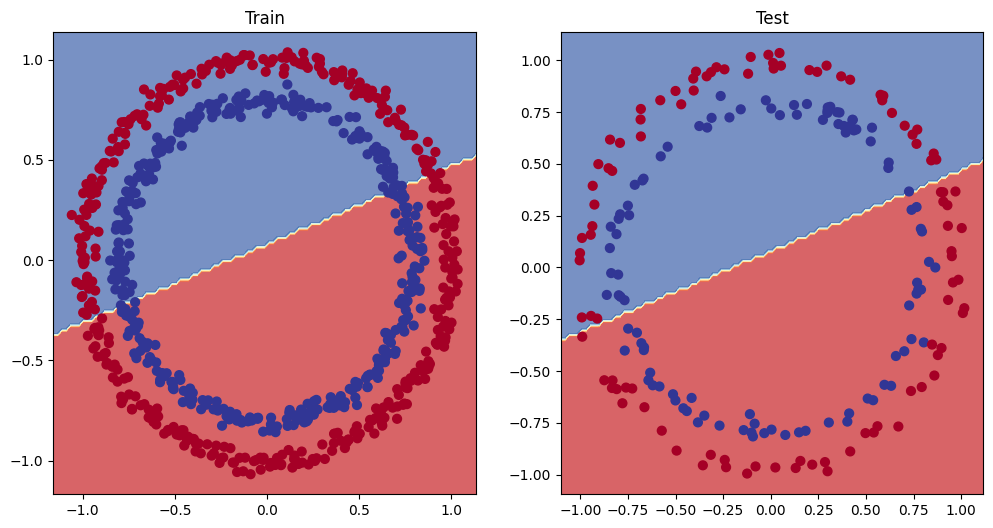

In [24]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

## 1.5. Improve through experimentation

There are two ways to improve a deep learning model:

* **Feature engineering**: adjusting the inputs to the model (e.g. using a different dataset, scaling, etc.)
* **Hyperparameter tuning**: adjusting the configuration of the model (e.g. number of layers, number of hidden units, learning rate, etc.)
 
From a model's perspective, hyperparameter tuning is the most important. If the model is not learning, it doesn't matter how good the features are. However, if the model is learning, it can be improved by better features. Some common hyperparameters to tune are:

* Add more layers: give the model more chances to learn complex relationships between features and labels
* Add more neurons: each layer will have more parameters to learn from (but don't go too high or the model will overfit)
* Train for longer: give the model more chances to learn the patterns in the data (but don't go too long or the model will overfit)
* Change the activation function: can help the model learn in different fashion (e.g. ReLU vs. Tanh)
* Change the learning rate: can speed up training if the model is learning slowly (but don't go too high or the weights will explode)
* Change the loss function: can help model learn faster (e.g. BCEWithLogitsLoss vs. MSE)
* Change the optimizer: can help model learn faster (e.g. Adam vs. SGD)

In [25]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

model1 = nn.Sequential(
  nn.Linear(in_features=2, out_features=256),
  nn.Linear(in_features=256, out_features=128),
  nn.Linear(in_features=128, out_features=64),
  nn.Linear(in_features=64, out_features=32),
  nn.Linear(in_features=32, out_features=16),
  nn.Linear(in_features=16, out_features=8),
  nn.Linear(in_features=8, out_features=4),
  nn.Linear(in_features=4, out_features=2),
  nn.Linear(in_features=2, out_features=1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model1.parameters(), lr=0.1)

model1.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=256, bias=True)
  (1): Linear(in_features=256, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Linear(in_features=16, out_features=8, bias=True)
  (6): Linear(in_features=8, out_features=4, bias=True)
  (7): Linear(in_features=4, out_features=2, bias=True)
  (8): Linear(in_features=2, out_features=1, bias=True)
)

In [26]:
train_eval_loop(
  model=model1, 
  loss_fn=loss_fn, 
  optim=optim, 
  X_train=X_train, 
  y_train=y_train, 
  X_test=X_test, 
  y_test=y_test,
  epochs=1001,
  verbose_every=100
)

epoch: 0, loss: 0.72, accuracy: 0.50%, f1: 0.33
epoch: 100, loss: 0.69, accuracy: 0.50%, f1: 0.33
epoch: 200, loss: 0.69, accuracy: 0.50%, f1: 0.33
epoch: 300, loss: 0.69, accuracy: 0.46%, f1: 0.45
epoch: 400, loss: 0.69, accuracy: 0.48%, f1: 0.48
epoch: 500, loss: 0.69, accuracy: 0.47%, f1: 0.47
epoch: 600, loss: 0.69, accuracy: 0.46%, f1: 0.46
epoch: 700, loss: 0.69, accuracy: 0.47%, f1: 0.47
epoch: 800, loss: 0.69, accuracy: 0.47%, f1: 0.46
epoch: 900, loss: 0.69, accuracy: 0.47%, f1: 0.47
epoch: 1000, loss: 0.69, accuracy: 0.47%, f1: 0.47


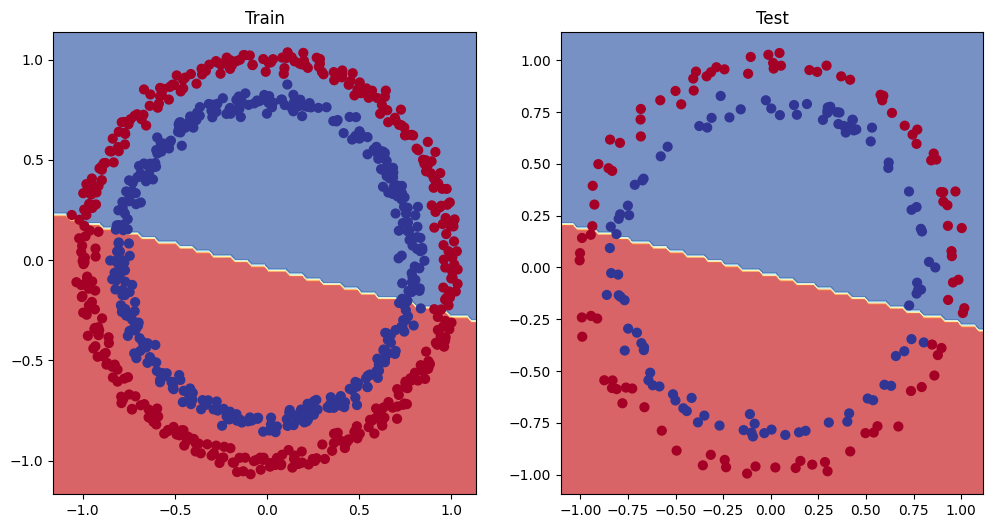

In [27]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

## 1.6. The missing piece: Introducing non-linearity to the model

##### 🤔 *"What could you draw if you had an unlimited amount of straight (linear) and non-straight (non-linear) lines?"*

Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

In the end of the day, they are a combination of linear and non-linear functions. The linear functions are the layers themselves, while the non-linear functions are the activation functions. The activation functions are applied to the outputs of the linear functions, and are what give neural networks their power.

* `nn.ReLU` implements the ReLU for **hidden** activation function, which is commonly used in neural networks.

Of course, the model was not fitting properly before because it was only using linear functions. So, let's add some non-linear functions to the model and see if it improves.

In [28]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

model2 = nn.Sequential(
  nn.Linear(in_features=2, out_features=32),
  nn.ReLU(),
  nn.Linear(in_features=32, out_features=32),
  nn.ReLU(),
  nn.Linear(in_features=32, out_features=32),
  nn.ReLU(),
  nn.Linear(in_features=32, out_features=1)
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optim = torch.optim.SGD(params=model2.parameters(), lr=0.1)

model2.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=1, bias=True)
)

In [29]:
train_eval_loop(
  model=model2, 
  loss_fn=loss_fn, 
  optim=optim, 
  X_train=X_train, 
  y_train=y_train, 
  X_test=X_test, 
  y_test=y_test,
  epochs=1001,
  verbose_every=100
)

epoch: 0, loss: 0.69, accuracy: 0.50%, f1: 0.33
epoch: 100, loss: 0.69, accuracy: 0.57%, f1: 0.53
epoch: 200, loss: 0.69, accuracy: 0.58%, f1: 0.56
epoch: 300, loss: 0.69, accuracy: 0.59%, f1: 0.56
epoch: 400, loss: 0.68, accuracy: 0.60%, f1: 0.58
epoch: 500, loss: 0.67, accuracy: 0.79%, f1: 0.78
epoch: 600, loss: 0.65, accuracy: 0.85%, f1: 0.85
epoch: 700, loss: 0.55, accuracy: 0.98%, f1: 0.98
epoch: 800, loss: 0.47, accuracy: 0.63%, f1: 0.57
epoch: 900, loss: 0.34, accuracy: 0.80%, f1: 0.79
epoch: 1000, loss: 0.07, accuracy: 1.00%, f1: 1.00


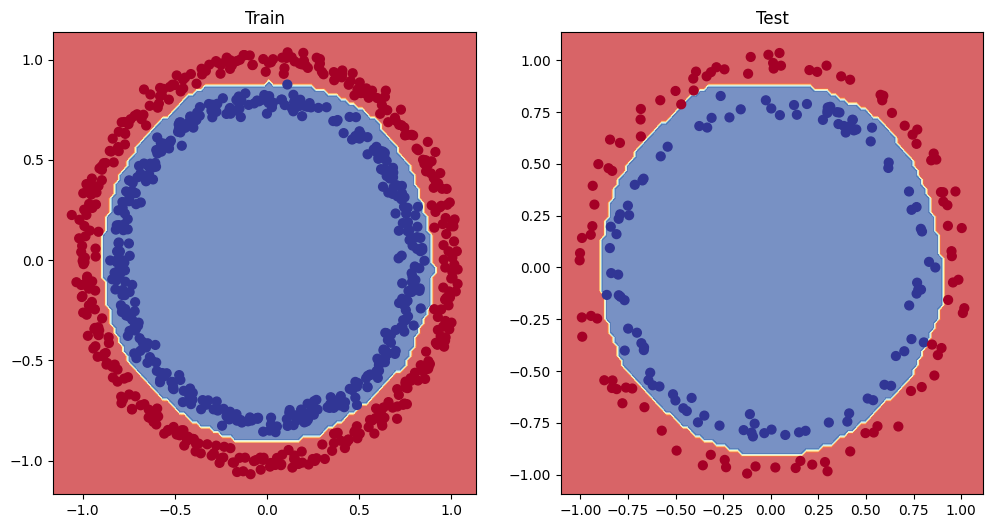

In [30]:
from helper_functions import plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model2, X_test, y_test)

# 2. Multiclass classification

Multiclass classification is a supervised learning problem in which we want to predict the class of an observation among three or more possible classes. In this type of problem, the model must output a probability for each class, and the predicted class is the one with the highest probability.

## 2.1. Get data ready

### 2.1.1. Create a dummy dataset for multiclass classification

In [31]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, n_features=2, cluster_std=1.5, centers=4, random_state=42)

In [32]:
X.shape, type(X), X.dtype, y.shape, type(y), y.dtype

((1000, 2),
 numpy.ndarray,
 dtype('float64'),
 (1000,),
 numpy.ndarray,
 dtype('int64'))

In [33]:
circles = pd.DataFrame({"X0": X[:, 0], "X1": X[:, 1], "label": y})
circles.head()

,X0,X1,label
0,-8.413396,6.935165,3
1,-5.766484,-6.431171,2
2,-6.042137,-6.766102,2
3,3.950837,0.698403,1
4,4.250492,-0.281545,1


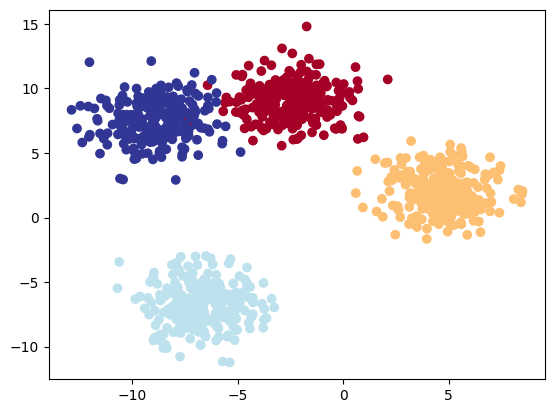

In [34]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

### 2.1.2. Turn data into tensors

In [35]:
# `torch.tensor()`: copy the original data, not sharing memory, and can work with a broader range of data types
# `torch.from_numpy()`: tensor shares memory with a numpy array, thus saving memory

X = torch.from_numpy(X).float()
y = torch.from_numpy(y).type(torch.LongTensor)

X.shape, type(X), X.dtype, y.shape, type(y), y.dtype

(torch.Size([1000, 2]),
 torch.Tensor,
 torch.float32,
 torch.Size([1000]),
 torch.Tensor,
 torch.int64)

### 2.1.3. Make train/test splits

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [37]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

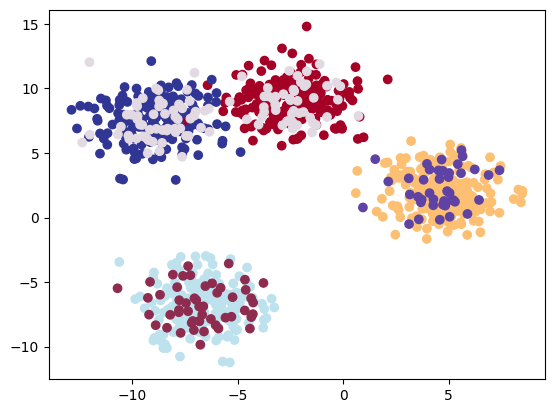

In [38]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=plt.cm.RdYlBu)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=plt.cm.twilight)
plt.show();

## 2.2. Build a model

* `nn.CrossEntropyLoss` computes the cross entropy loss between the predicted probabilities and the true labels. It is commonly used in multiclass classification problems.

* `nn.Softmax` implements the softmax for **output** activation function, which is commonly used in multiclass classification problems.

In [39]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

model3 = nn.Sequential(
  nn.Linear(in_features=2, out_features=16),
  nn.ReLU(),
  nn.Linear(in_features=16, out_features=16),
  nn.ReLU(),
  nn.Linear(in_features=16, out_features=4)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.SGD(params=model3.parameters(), lr=0.1)

model3.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=4, bias=True)
)

## 2.3. Fit the model to the data (train and eval loop)

The model outputs raw **logits**, which are passed into an activation function (softmax) to get **predicted probabilities**. These probabilities are then converted to prediction labels by taking the argmax.

In [40]:
model3.eval()
with torch.inference_mode():
  logits = model3(X_train).squeeze()
logits[:5]

tensor([[-0.5290,  0.0797,  0.5474, -0.3397],
        [-0.2099, -0.0837, -0.5981, -0.1755],
        [-0.5065, -0.3383, -0.9062, -0.4618],
        [-0.3013, -0.1332, -0.6856, -0.3080],
        [-0.1536, -0.0494, -0.5880, -0.2915]])

In [41]:
preds_probs = torch.softmax(logits, dim=1)
preds_probs[:5]

tensor([[0.1433, 0.2633, 0.4203, 0.1731],
        [0.2599, 0.2948, 0.1763, 0.2690],
        [0.2565, 0.3034, 0.1720, 0.2682],
        [0.2593, 0.3067, 0.1765, 0.2575],
        [0.2756, 0.3058, 0.1785, 0.2401]])

In [42]:
preds = torch.argmax(preds_probs, dim=1)
preds[:5]

tensor([2, 1, 1, 1, 1])

In [43]:
# set seed for reproducibility
torch.manual_seed(42), torch.cuda.manual_seed(42)

# put data on the GPU if available
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

# training and evaluation loop
for epoch in range(101):
  model3.train()

  # forward pass
  logits = model3(X_train).squeeze()
  preds = torch.softmax(logits, dim=1).argmax(dim=1)

  # calculate loss
  loss = loss_fn(logits, y_train)

  # optimizer zero grad
  optim.zero_grad()

  # backward pass (backpropagation)
  loss.backward()

  # update the weights (gradient descent)
  optim.step()

  # evaluation loop
  model3.eval()
  with torch.inference_mode():
    logits = model3(X_test).squeeze()
    preds = torch.softmax(logits, dim=1).argmax(dim=1)

    loss = loss_fn(logits, y_test)
    eval_metrics = compute_metrics(y_test, preds)

  if epoch % 10 == 0:
    print(f"epoch: {epoch}, loss: {loss.item():.2f}, accuracy: {eval_metrics['accuracy']:.2f}%, f1: {eval_metrics['f1']:.2f}")

epoch: 0, loss: 1.21, accuracy: 0.12%, f1: 0.08
epoch: 10, loss: 0.32, accuracy: 1.00%, f1: 1.00
epoch: 20, loss: 0.12, accuracy: 0.99%, f1: 1.00
epoch: 30, loss: 0.07, accuracy: 0.99%, f1: 1.00
epoch: 40, loss: 0.05, accuracy: 0.99%, f1: 1.00
epoch: 50, loss: 0.04, accuracy: 0.99%, f1: 1.00
epoch: 60, loss: 0.03, accuracy: 0.99%, f1: 1.00
epoch: 70, loss: 0.03, accuracy: 0.99%, f1: 1.00
epoch: 80, loss: 0.03, accuracy: 0.99%, f1: 1.00
epoch: 90, loss: 0.03, accuracy: 0.99%, f1: 1.00
epoch: 100, loss: 0.02, accuracy: 0.99%, f1: 1.00


## 2.4. Evaluate the model

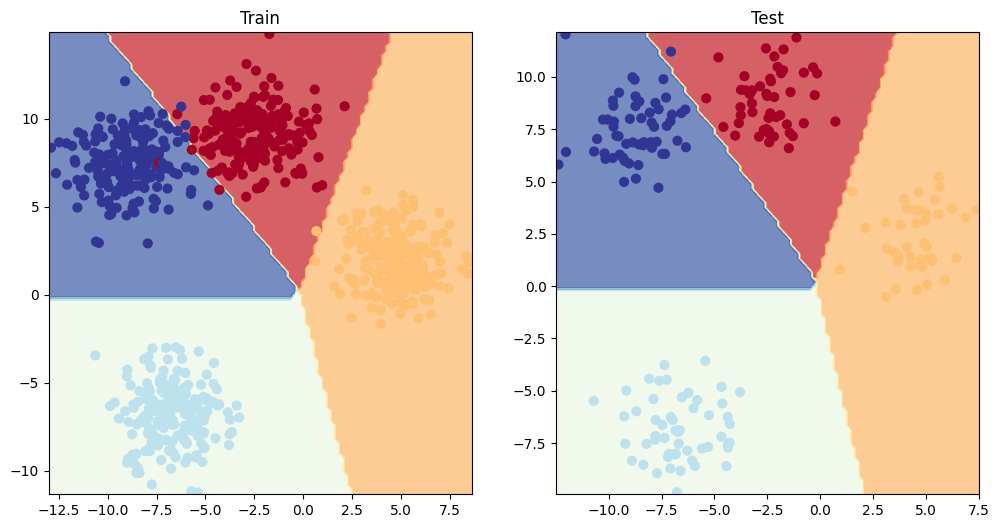

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

In [45]:
try:
  from torchmetrics import Accuracy
except:
  !pipenv install torchmetrics
  from torchmetrics import Accuracy

torchmetric_accuracy = Accuracy(task="multiclass", num_classes=4).to(device)

torchmetric_accuracy(preds, y_test)

tensor(0.9950)

# References:

1. [Batch 32 - Yann LeCun @ Twitter](https://twitter.com/ylecun/status/989610208497360896)
2. [Beyond accuracy: precision and recall - Towards Data Science](https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c)
3. [MIT's Introduction to deep learning - Youtube](https://youtu.be/7sB052Pz0sQ)
4. [Ground truth notebook](https://www.learnpytorch.io/02_pytorch_classification/)